### Import Packages

In [1]:
from IPython.display import Image, display
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import time
import pickle
import wave, struct
import math
from scipy.fftpack import fft
import scipy
from shutil import copyfile
import pylab
from scipy.io import wavfile
import logging
import random
import PIL.Image
from scipy.ndimage.filters import gaussian_filter
import inception5h
%matplotlib inline
import tensorflow as tf
import librosa
from shutil import copyfile

### Define Functions

In [2]:
def load_image(filename):
    image = PIL.Image.open(filename)
    return np.float32(image)

In [3]:
def save_image(image, filename):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)
    
    # Convert to bytes.
    image = image.astype(np.uint8)
    
    # Write the image-file in jpeg-format.
    with open(filename, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')

In [4]:
def plot_image(image):
    # Assume the pixel-values are scaled between 0 and 255.
    
    if False:
        # Convert the pixel-values to the range between 0.0 and 1.0
        image = np.clip(image/255.0, 0.0, 1.0)
        
        # Plot using matplotlib.
        plt.imshow(image, interpolation='lanczos')
        plt.show()
    else:
        # Ensure the pixel-values are between 0 and 255.
        image = np.clip(image, 0.0, 255.0)
        
        # Convert pixels to bytes.
        image = image.astype(np.uint8)

        # Convert to a PIL-image and display it.
        display(PIL.Image.fromarray(image))

In [5]:
def normalize_image(x):
    # Get the min and max values for all pixels in the input.
    x_min = x.min()
    x_max = x.max()

    # Normalize so all values are between 0.0 and 1.0
    x_norm = (x - x_min) / (x_max - x_min)
    
    return x_norm

In [6]:
def plot_gradient(gradient):
    # Normalize the gradient so it is between 0.0 and 1.0
    gradient_normalized = normalize_image(gradient)
    
    # Plot the normalized gradient.
    plt.imshow(gradient_normalized, interpolation='bilinear')
    plt.show()

In [7]:
def resize_image(image, size=None, factor=None):
    # If a rescaling-factor is provided then use it.
    if factor is not None:
        # Scale the numpy array's shape for height and width.
        size = np.array(image.shape[0:2]) * factor
        
        # The size is floating-point because it was scaled.
        # PIL requires the size to be integers.
        size = size.astype(int)
    else:
        # Ensure the size has length 2.
        size = size[0:2]
    
    # The height and width is reversed in numpy vs. PIL.
    size = tuple(reversed(size))

    # Ensure the pixel-values are between 0 and 255.
    img = np.clip(image, 0.0, 255.0)
    
    # Convert the pixels to 8-bit bytes.
    img = img.astype(np.uint8)
    
    # Create PIL-object from numpy array.
    img = PIL.Image.fromarray(img)
    
    # Resize the image.
    img_resized = img.resize(size, PIL.Image.LANCZOS)
    
    # Convert 8-bit pixel values back to floating-point.
    img_resized = np.float32(img_resized)

    return img_resized

In [8]:
def get_tile_size(num_pixels, tile_size=400):
    """
    num_pixels is the number of pixels in a dimension of the image.
    tile_size is the desired tile-size.
    """

    # How many times can we repeat a tile of the desired size.
    num_tiles = int(round(num_pixels / tile_size))
    
    # Ensure that there is at least 1 tile.
    num_tiles = max(1, num_tiles)
    
    # The actual tile-size.
    actual_tile_size = math.ceil(num_pixels / num_tiles)
    
    return actual_tile_size

In [9]:
def tiled_gradient(gradient, image, tile_size=400):
    # Allocate an array for the gradient of the entire image.
    grad = np.zeros_like(image)

    # Number of pixels for the x- and y-axes.
    x_max, y_max, _ = image.shape

    # Tile-size for the x-axis.
    x_tile_size = get_tile_size(num_pixels=x_max, tile_size=tile_size)
    # 1/4 of the tile-size.
    x_tile_size4 = x_tile_size // 4

    # Tile-size for the y-axis.
    y_tile_size = get_tile_size(num_pixels=y_max, tile_size=tile_size)
    # 1/4 of the tile-size
    y_tile_size4 = y_tile_size // 4

    # Random start-position for the tiles on the x-axis.
    # The random value is between -3/4 and -1/4 of the tile-size.
    # This is so the border-tiles are at least 1/4 of the tile-size,
    # otherwise the tiles may be too small which creates noisy gradients.
    x_start = random.randint(-3*x_tile_size4, -x_tile_size4)
    while x_start < x_max:
        # End-position for the current tile.
        x_end = x_start + x_tile_size
        
        # Ensure the tile's start- and end-positions are valid.
        x_start_lim = max(x_start, 0)
        x_end_lim = min(x_end, x_max)

        # Random start-position for the tiles on the y-axis.
        # The random value is between -3/4 and -1/4 of the tile-size.
        y_start = random.randint(-3*y_tile_size4, -y_tile_size4)

        while y_start < y_max:
            # End-position for the current tile.
            y_end = y_start + y_tile_size

            # Ensure the tile's start- and end-positions are valid.
            y_start_lim = max(y_start, 0)
            y_end_lim = min(y_end, y_max)

            # Get the image-tile.
            img_tile = image[x_start_lim:x_end_lim,
                             y_start_lim:y_end_lim, :]

            # Create a feed-dict with the image-tile.
            feed_dict = model.create_feed_dict(image=img_tile)

            # Use TensorFlow to calculate the gradient-value.
            g = session.run(gradient, feed_dict=feed_dict)

            # Normalize the gradient for the tile. This is
            # necessary because the tiles may have very different
            # values. Normalizing gives a more coherent gradient.
            g /= (np.std(g) + 1e-8)

            # Store the tile's gradient at the appropriate location.
            grad[x_start_lim:x_end_lim,
                 y_start_lim:y_end_lim, :] = g
            
            # Advance the start-position for the y-axis.
            y_start = y_end

        # Advance the start-position for the x-axis.
        x_start = x_end

    return grad

In [10]:
def optimize_image_save_iters(max_expG,im_file_base,layer_tensor, image,
                   num_iterations=10, step_size=3.0, tile_size=400,
                   show_gradient=False):
    """
    Use gradient ascent to optimize an image so it maximizes the
    mean value of the given layer_tensor.
    
    Parameters:
    layer_tensor: Reference to a tensor that will be maximized.
    image: Input image used as the starting point.
    num_iterations: Number of optimization iterations to perform.
    step_size: Scale for each step of the gradient ascent.
    tile_size: Size of the tiles when calculating the gradient.
    show_gradient: Plot the gradient in each iteration.
    """

    # Copy the image so we don't overwrite the original image.
    img = image.copy()
    #img_return = image.copy()
    
    #print("Image before:")
    #plot_image(img)

    print("Processing image: ", end="")

    # Use TensorFlow to get the mathematical function for the
    # gradient of the given layer-tensor with regard to the
    # input image. This may cause TensorFlow to add the same
    # math-expressions to the graph each time this function is called.
    # It may use a lot of RAM and could be moved outside the function.
    gradient = model.get_gradient(layer_tensor)
    for i in range(max_expG+1): #range(num_iterations+10):
        # Calculate the value of the gradient.
        # This tells us how to change the image so as to
        # maximize the mean of the given layer-tensor.
        grad = tiled_gradient(gradient=gradient, image=img,
                              tile_size=tile_size)
        
        # Blur the gradient with different amounts and add
        # them together. The blur amount is also increased
        # during the optimization. This was found to give
        # nice, smooth images. You can try and change the formulas.
        # The blur-amount is called sigma (0=no blur, 1=low blur, etc.)
        # We could call gaussian_filter(grad, sigma=(sigma, sigma, 0.0))
        # which would not blur the colour-channel. This tends to
        # give psychadelic / pastel colours in the resulting images.
        # When the colour-channel is also blurred the colours of the
        # input image are mostly retained in the output image.
        sigma = (i * 4.0) / num_iterations + 0.5
        grad_smooth1 = gaussian_filter(grad, sigma=sigma)
        grad_smooth2 = gaussian_filter(grad, sigma=sigma*2)
        grad_smooth3 = gaussian_filter(grad, sigma=sigma*0.5)
        grad = (grad_smooth1 + grad_smooth2 + grad_smooth3)

        # Scale the step-size according to the gradient-values.
        # This may not be necessary because the tiled-gradient
        # is already normalized.
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Update the image by following the gradient.
        img += grad * step_size_scaled
        
        #filename_pre = 'im' + str(framenum).zfill(5) + '.png'
        
        filename = im_file_base + str(i) + '.pckl'
        
        tmp = open(filename, 'wb')
        pickle.dump(img, tmp)
        tmp.close()
        
        if i == num_iterations-1:
            img_return = img
        
        
        #cv2.imwrite(filename, im_out) 
        
        if show_gradient:
            # Print statistics for the gradient.
            msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
            print(msg.format(grad.min(), grad.max(), step_size_scaled))

            # Plot the gradient.
            plot_gradient(grad)
        else:
            # Otherwise show a little progress-indicator.
            print(". ", end="")

    print()
    #print("Image after:")
    #plot_image(img)
    
    #return img
    return img_return

In [11]:
def optimize_image(layer_tensor, image,
                   num_iterations=10, step_size=3.0, tile_size=400,
                   show_gradient=False):
    """
    Use gradient ascent to optimize an image so it maximizes the
    mean value of the given layer_tensor.
    
    Parameters:
    layer_tensor: Reference to a tensor that will be maximized.
    image: Input image used as the starting point.
    num_iterations: Number of optimization iterations to perform.
    step_size: Scale for each step of the gradient ascent.
    tile_size: Size of the tiles when calculating the gradient.
    show_gradient: Plot the gradient in each iteration.
    """

    # Copy the image so we don't overwrite the original image.
    img = image.copy()
    
    #print("Image before:")
    #plot_image(img)

    print("Processing image: ", end="")

    # Use TensorFlow to get the mathematical function for the
    # gradient of the given layer-tensor with regard to the
    # input image. This may cause TensorFlow to add the same
    # math-expressions to the graph each time this function is called.
    # It may use a lot of RAM and could be moved outside the function.
    gradient = model.get_gradient(layer_tensor)
    for i in range(num_iterations):
        # Calculate the value of the gradient.
        # This tells us how to change the image so as to
        # maximize the mean of the given layer-tensor.
        grad = tiled_gradient(gradient=gradient, image=img,
                              tile_size=tile_size)
        
        # Blur the gradient with different amounts and add
        # them together. The blur amount is also increased
        # during the optimization. This was found to give
        # nice, smooth images. You can try and change the formulas.
        # The blur-amount is called sigma (0=no blur, 1=low blur, etc.)
        # We could call gaussian_filter(grad, sigma=(sigma, sigma, 0.0))
        # which would not blur the colour-channel. This tends to
        # give psychadelic / pastel colours in the resulting images.
        # When the colour-channel is also blurred the colours of the
        # input image are mostly retained in the output image.
        sigma = (i * 4.0) / num_iterations + 0.5
        grad_smooth1 = gaussian_filter(grad, sigma=sigma)
        grad_smooth2 = gaussian_filter(grad, sigma=sigma*2)
        grad_smooth3 = gaussian_filter(grad, sigma=sigma*0.5)
        grad = (grad_smooth1 + grad_smooth2 + grad_smooth3)

        # Scale the step-size according to the gradient-values.
        # This may not be necessary because the tiled-gradient
        # is already normalized.
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Update the image by following the gradient.
        img += grad * step_size_scaled

        if show_gradient:
            # Print statistics for the gradient.
            msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
            print(msg.format(grad.min(), grad.max(), step_size_scaled))

            # Plot the gradient.
            plot_gradient(grad)
        else:
            # Otherwise show a little progress-indicator.
            print(". ", end="")

    #print()
    #print("Image after:")
    #plot_image(img)
    
    return img

In [12]:
def recursive_optimize_save_iters(max_expG,im_file_base,layer_tensor, image,
                       num_repeats=4, rescale_factor=0.7, blend=0.2,
                       num_iterations=10, step_size=3.0,
                       tile_size=400):
    """
    Recursively blur and downscale the input image.
    Each downscaled image is run through the optimize_image()
    function to amplify the patterns that the Inception model sees.

    Parameters:
    image: Input image used as the starting point.
    rescale_factor: Downscaling factor for the image.
    num_repeats: Number of times to downscale the image.
    blend: Factor for blending the original and processed images.

    Parameters passed to optimize_image():
    layer_tensor: Reference to a tensor that will be maximized.
    num_iterations: Number of optimization iterations to perform.
    step_size: Scale for each step of the gradient ascent.
    tile_size: Size of the tiles when calculating the gradient.
    """

    # Do a recursive step?
    if num_repeats>0:
        # Blur the input image to prevent artifacts when downscaling.
        # The blur amount is controlled by sigma. Note that the
        # colour-channel is not blurred as it would make the image gray.
        sigma = 0.5
        img_blur = gaussian_filter(image, sigma=(sigma, sigma, 0.0))

        # Downscale the image.
        img_downscaled = resize_image(image=img_blur,
                                      factor=rescale_factor)
            
        # Recursive call to this function.
        # Subtract one from num_repeats and use the downscaled image.
        img_result = recursive_optimize(layer_tensor=layer_tensor,
                                        image=img_downscaled,
                                        num_repeats=num_repeats-1,
                                        rescale_factor=rescale_factor,
                                        blend=blend,
                                        num_iterations=num_iterations,
                                        step_size=step_size,
                                        tile_size=tile_size)
        
        # Upscale the resulting image back to its original size.
        img_upscaled = resize_image(image=img_result, size=image.shape)

        # Blend the original and processed images.
        image = blend * image + (1.0 - blend) * img_upscaled

    print("Recursive level:", num_repeats)
    
     # Process the image using the DeepDream algorithm.
    img_result = optimize_image_save_iters(max_expG,im_file_base,layer_tensor=layer_tensor,
                                image=image,
                                num_iterations=num_iterations,
                                step_size=step_size,
                                tile_size=tile_size)
    
    return img_result

In [13]:
def recursive_optimize(layer_tensor, image,
                       num_repeats=4, rescale_factor=0.7, blend=0.2,
                       num_iterations=10, step_size=3.0,
                       tile_size=400):
    """
    Recursively blur and downscale the input image.
    Each downscaled image is run through the optimize_image()
    function to amplify the patterns that the Inception model sees.

    Parameters:
    image: Input image used as the starting point.
    rescale_factor: Downscaling factor for the image.
    num_repeats: Number of times to downscale the image.
    blend: Factor for blending the original and processed images.

    Parameters passed to optimize_image():
    layer_tensor: Reference to a tensor that will be maximized.
    num_iterations: Number of optimization iterations to perform.
    step_size: Scale for each step of the gradient ascent.
    tile_size: Size of the tiles when calculating the gradient.
    """

    # Do a recursive step?
    if num_repeats>0:
        # Blur the input image to prevent artifacts when downscaling.
        # The blur amount is controlled by sigma. Note that the
        # colour-channel is not blurred as it would make the image gray.
        sigma = 0.5
        img_blur = gaussian_filter(image, sigma=(sigma, sigma, 0.0))

        # Downscale the image.
        img_downscaled = resize_image(image=img_blur,
                                      factor=rescale_factor)
            
        # Recursive call to this function.
        # Subtract one from num_repeats and use the downscaled image.
        img_result = recursive_optimize(layer_tensor=layer_tensor,
                                        image=img_downscaled,
                                        num_repeats=num_repeats-1,
                                        rescale_factor=rescale_factor,
                                        blend=blend,
                                        num_iterations=num_iterations,
                                        step_size=step_size,
                                        tile_size=tile_size)
        
        # Upscale the resulting image back to its original size.
        img_upscaled = resize_image(image=img_result, size=image.shape)

        # Blend the original and processed images.
        image = blend * image + (1.0 - blend) * img_upscaled

    print("Recursive level:", num_repeats)
    
     # Process the image using the DeepDream algorithm.
    img_result = optimize_image(layer_tensor=layer_tensor,
                                image=image,
                                num_iterations=num_iterations,
                                step_size=step_size,
                                tile_size=tile_size)
    
    return img_result

In [14]:
def mymkdir(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

## Start of Main Code 

In [15]:
# Instantiate neural network model
inception5h.data_dir = 'inception/5h/'
inception5h.maybe_download()
model = inception5h.Inception5h()
session = tf.InteractiveSession(graph=model.graph)
print('Number of layers in neural net: ',len(model.layer_tensors))

Data has apparently already been downloaded and unpacked.
Instructions for updating:
Use tf.gfile.GFile.
Number of layers in neural net:  12


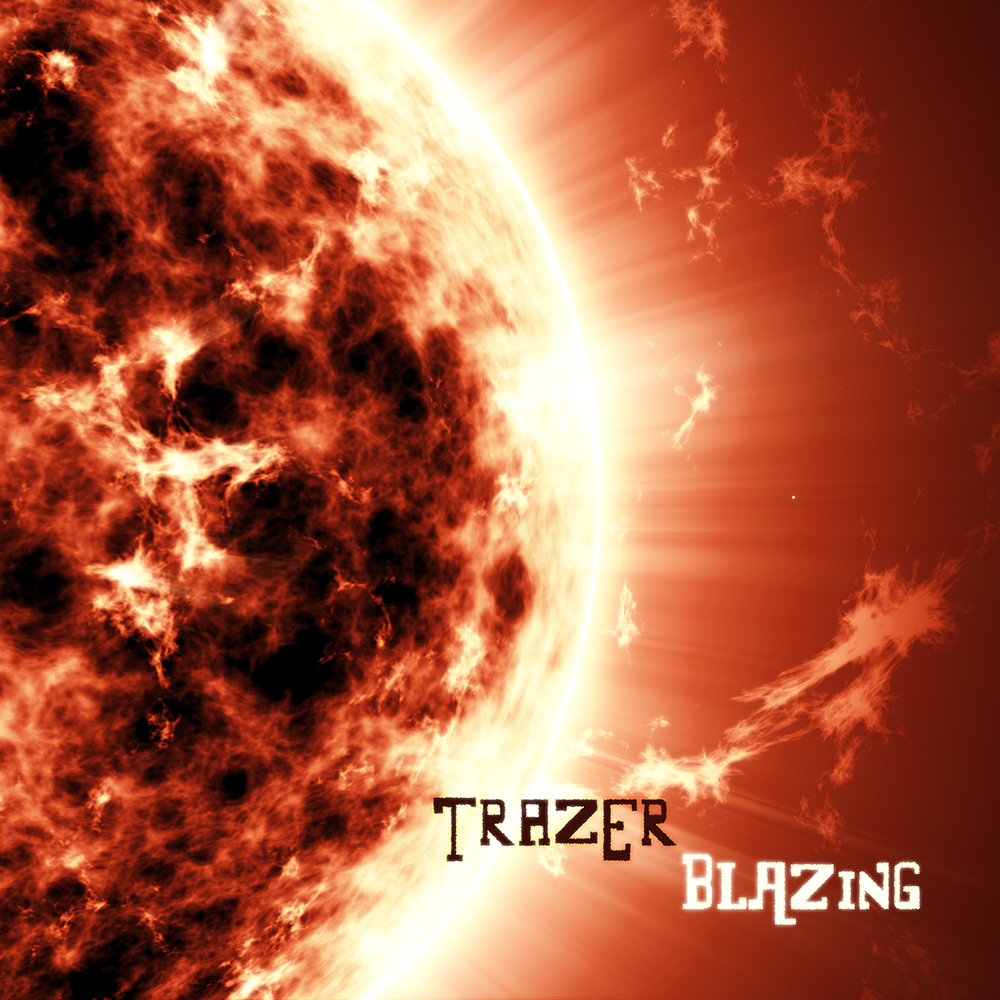

In [29]:
# Load image of interest
#file_im = 'images/Tony_MG_9995s.jpg'
#file_im = 'images/Earth_crop2.jpg'
file_im = 'images/Blazing1000.png'
image = load_image(filename=file_im)
plot_image(image)

In [30]:
layer_tensor = model.layer_tensors[2]

In [223]:
# Set some variables and create some folders to store the results
# (many of these variables are not used in the current code)

#newpath = 'TTMDemoFiles/'
#newpath = 'TTMFull/'
newpath = 'Blazing/'
#music_file = 'TTMDemo.wav'
#music_file = 'TTM.wav'
#music_file = 'Blazing.wav'
music_file = 'BlazingCrop1.wav'
vers = '1'
newpath_files = newpath + 'Files' + vers + '/'
newpath_ims = newpath + 'im_gen' + vers + '/'
newpath_layers = newpath + 'Ex_layers' + vers + '/'
newpath_layers2 = newpath + 'Ex_layers' + vers + '_all/'

mymkdir(newpath)
mymkdir(newpath_files)    
mymkdir(newpath_ims)
mymkdir(newpath_layers)
mymkdir(newpath_layers2)
    
# Backup this notebook, so we know exactly which version was used
pyfile = 'DeepDreamViz.ipynb'
destfile = newpath_files + pyfile
copyfile(pyfile,destfile)
    
fps = 30;

do_mids = 0        #(480-2940 Hz) Mids (piano)
do_low_highs = 0    #(2940-7020 Hz) Low Highs 
do_highs = 0        #(7080-22k Hz) Highs 

In [224]:
fs, frames = librosa.load(music_file, sr=None)
frames

44100

Calculating music file... Blazing/Files1/BlazingCrop130.pckl
Saved music file... Blazing/Files1/BlazingCrop130.pckl
(3699, 11)


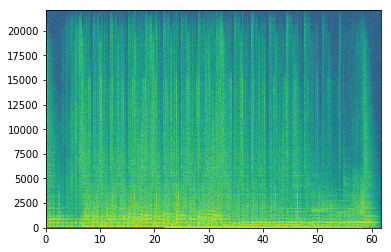

In [323]:
# Import the song from "music_file" and calculate the fourier transform, and save it.

do_music_load = 1
file_len = len(music_file)        
file_music_pkl = newpath_files + music_file[0:file_len-4] +str(fps) + '.pckl'
if os.path.isfile(file_music_pkl) and do_music_load and 0: 
    print('Loading presaved music file...',file_music_pkl)
    fmusic = open(file_music_pkl, 'rb')
    [Pxx,freqs,t,fs,frames,songFramerate,myNFFT] = pickle.load(fmusic)
    fmusic.close()
else:
    print('Calculating music file...',file_music_pkl)        
    w = wave.open(music_file,'r')
    songFramerate = w.getframerate() #44100
    frames,fs  = librosa.load(music_file, sr=None, mono=False)
    channels = [np.array(frames[0,:]),np.array(frames[ 1,:])]
    
    # generate specgram
    myNFFT = np.int(songFramerate/fps) #4096
    Pxx, freqs, t, plot = pylab.specgram(
        channels[0], NFFT=myNFFT,Fs=songFramerate, 
        detrend=pylab.detrend_none, window=pylab.window_hanning,
        noverlap=int(myNFFT * 0.5))
    fmusic = open(file_music_pkl, 'wb')
    pickle.dump([Pxx,freqs,t,fs,frames,songFramerate,myNFFT], fmusic)
    fmusic.close()
    print('Saved music file...',file_music_pkl)

nt = np.size(Pxx,axis=1) #number of timesteps
nf = np.size(Pxx,axis=0) #number of frequencies
maxfs = np.zeros((nt,11));
for i in range(0,nt):
    maxfs[i,0] = t[i]                           #time
    maxfs[i,1] = freqs[np.argmax(Pxx[:,i])]  #Freq w/max vol
    maxfs[i,2] = np.log10(maxfs[i,1])        #log(Freq w/max vol)
    maxfs[i,3] = np.max(Pxx[:,i])            #Max vol
    maxfs[i,4] = np.log10(maxfs[i,3])        #log(Max vol)
    #maxfs[i,5] = np.sum(Pxx[0:9,i])          #(0-120 Hz) bass #depends!!! 
    maxfs[i,5] = np.sum(Pxx[0:5,i])          #(0-120 Hz) bass #depends!!! 
    maxfs[i,6] = np.sum(Pxx[3:8,i])          #(120-480Hz) high bass   
    maxfs[i,7] = np.sum(Pxx[9:100,i])         #(480-2940 Hz) Mids 
    maxfs[i,8] = np.sum(Pxx[50:117,i])       #(2940-7020 Hz) Low Highs 
    maxfs[i,9] = np.sum(Pxx[118:367,i])     #(7080-22k Hz) Highs 

maxpeak = np.max(maxfs[:,3])
maxfreq = np.max(maxfs[:,1])

maxfs[:,3] = maxfs[:,3]/maxpeak
maxfs[:,4] = maxfs[:,4]/np.log10(maxpeak)
for i in range(5,10):
    maxfs[:,i] = maxfs[:,i]/np.max(maxfs[:,i])
plt.plot(t[1:1300],maxfs[1:1300,5])
print(np.shape(maxfs))

In [328]:
intensity = maxfs[:,5]
for i in range(6,7):
    intensity += maxfs[:,i]

In [329]:
intensity[intensity>1]=1

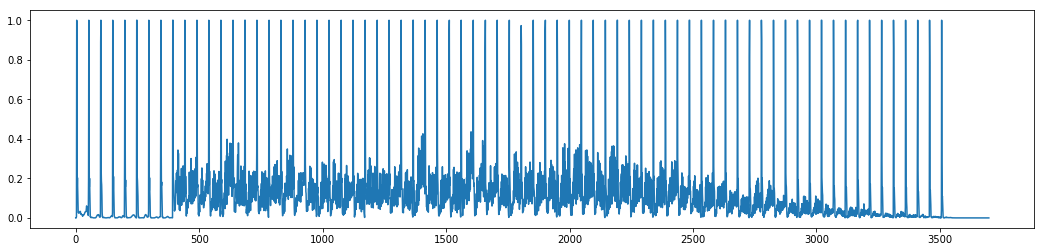

In [330]:
# Plot the intensity of the kick drum over time
plt.figure(figsize=(18, 4))
plt.plot(intensity)

In [331]:
# Calculate max_expG, i.e. the maximum depth to which the algorithm will go. 
# (this is based on the maximum intensity for the frequency range 0-120Hz)

tempmax = intensity.max()
tempmin = intensity.min()
expG_temp = 1+tempmax
tuner = 22
varA = 40 - tuner
varB = 46 - tuner
max_expG = max([1,int(round(expG_temp*varA-varB,0))])
min_expG = max([1,int(round(tempmin*varA-varB,0))])
print(max_expG, min_expG)

12 1


In [332]:
# Loop through each timestep and save the image.

framenum = 0; 
 
#layer_tensor = model.layer_tensors[7][:,:,:,0:3]
rand = random.randint(3,11)
do_random = 0
which_layer = 4
#intensity = maxfs[:,5]
intensity2 = intensity

while framenum*2+1<maxfs.shape[0]: 
    ttemp3 = time.time()

    framenum = framenum+1;  
    f2 = framenum*2
    isfirst = 0
    bassweight = 1 
    bassintensity = maxfs[framenum*2,5]
    
    bass_method = 3
    if bass_method == 1:
        if intensity[(framenum-1)*2]>bassintensity:
            intensity[framenum*2] = 0.95*intensity[(framenum-1)*2] 
            bassintensity = intensity[framenum*2]
    elif bass_method == 2:
        expGtmp = max([1,int(round((intensity[(framenum)*2]+1)*varA-varB,0))])
        if expGtmp < 10:
            intensity[framenum*2] = 0.95*intensity[(framenum-1)*2] 
        
        bassintensity = intensity[framenum*2]
        print(expGtmp)
    elif bass_method == 3:
        if intensity[f2-4] < intensity[f2] and intensity[f2-2] < intensity[f2] and intensity[f2+2] < intensity[f2]:
            intensity2[f2] = 1
            isfirst = 1
        
        elif intensity[f2-2] > intensity[f2]:
            intensity2[f2] = 0.95*intensity2[f2-2]
        bassintensity = intensity2[f2]

    expG = 1+bassweight*bassintensity 
    expG_pre = expG
    
    #new lines
    if do_random == 0:
        rand = which_layer
    expG = max([1,int(round(expG*varA-varB,0))])
    
    file_dd = newpath_files + 'dd_' + str(rand) + '_' + str(expG) + '.pckl'
    im_file_base = newpath_files + 'dd_' + str(rand) + '_'
    filename = newpath_ims + 'im' + str(framenum).zfill(5) + '.png' 
    filename2 = newpath_layers2 + 'im' + str(rand) + '_' + str(expG) + '.png' 
    
    save_im_layers = 1
    if os.path.isfile(filename2) == True and save_im_layers:
        copyfile(filename2, filename)
        print(expG,bassintensity,intensity[framenum*2],round(expG_pre,4), file_dd, filename, ' (copied)')
        continue
        
    print(expG,round(expG_pre,4), file_dd, filename)
    
    # If file_dd already exists with image, load it. Otherwise, use deep dream
    if os.path.isfile(file_dd):
        tmp = open(file_dd, 'rb')
        im = pickle.load(tmp)
        tmp.close()
    else:        
        #Deep dream ==========================
        layer_tensor = model.layer_tensors[rand][:,:,:,0:3]
        im = recursive_optimize_save_iters(max_expG,im_file_base,layer_tensor=layer_tensor, image=image,
                         num_iterations=expG, step_size=3.0, rescale_factor=0.7,
                         num_repeats=4, blend=0.65)
        
        tmp = open(file_dd, 'wb')
        pickle.dump(im, tmp)
        tmp.close()
            
    im_out = cv2.cvtColor(im, cv2.COLOR_RGB2BGR) 
    cv2.imwrite(filename, im_out) 
    
    # output demo image of this layer
    if isfirst == 1:                
        filename_demo = newpath_layers + 'im' + str(rand) + '.png'  
        if os.path.isfile(filename_demo) == False:
            print(filename_demo)
            cv2.imwrite(filename_demo, im_out)
        
    if save_im_layers:         
        if os.path.isfile(filename2) == False:
            cv2.imwrite(filename2, im_out)

    print(expG,round(expG_pre,4), file_dd, filename)
     

1 0.00028557038013881487 0.00028557038013881487 1.0003 Blazing/Files1/dd_4_1.pckl Blazing/im_gen1/im00001.png  (copied)
12 1.0 1.0 2.0 Blazing/Files1/dd_4_12.pckl Blazing/im_gen1/im00002.png  (copied)
11 0.95 0.95 1.95 Blazing/Files1/dd_4_11.pckl Blazing/im_gen1/im00003.png  (copied)
10 0.9025 0.9025 1.9025 Blazing/Files1/dd_4_10.pckl Blazing/im_gen1/im00004.png  (copied)
9 0.8573749999999999 0.8573749999999999 1.8574 Blazing/Files1/dd_4_9.pckl Blazing/im_gen1/im00005.png  (copied)
9 0.8145062499999999 0.8145062499999999 1.8145 Blazing/Files1/dd_4_9.pckl Blazing/im_gen1/im00006.png  (copied)
8 0.7737809374999999 0.7737809374999999 1.7738 Blazing/Files1/dd_4_8.pckl Blazing/im_gen1/im00007.png  (copied)
7 0.7350918906249998 0.7350918906249998 1.7351 Blazing/Files1/dd_4_7.pckl Blazing/im_gen1/im00008.png  (copied)
7 0.6983372960937497 0.6983372960937497 1.6983 Blazing/Files1/dd_4_7.pckl Blazing/im_gen1/im00009.png  (copied)
6 0.6634204312890623 0.6634204312890623 1.6634 Blazing/Files1/dd_

10 0.9025 0.9025 1.9025 Blazing/Files1/dd_4_10.pckl Blazing/im_gen1/im00102.png  (copied)
9 0.8573749999999999 0.8573749999999999 1.8574 Blazing/Files1/dd_4_9.pckl Blazing/im_gen1/im00103.png  (copied)
9 0.8145062499999999 0.8145062499999999 1.8145 Blazing/Files1/dd_4_9.pckl Blazing/im_gen1/im00104.png  (copied)
8 0.7737809374999999 0.7737809374999999 1.7738 Blazing/Files1/dd_4_8.pckl Blazing/im_gen1/im00105.png  (copied)
7 0.7350918906249998 0.7350918906249998 1.7351 Blazing/Files1/dd_4_7.pckl Blazing/im_gen1/im00106.png  (copied)
7 0.6983372960937497 0.6983372960937497 1.6983 Blazing/Files1/dd_4_7.pckl Blazing/im_gen1/im00107.png  (copied)
6 0.6634204312890623 0.6634204312890623 1.6634 Blazing/Files1/dd_4_6.pckl Blazing/im_gen1/im00108.png  (copied)
5 0.6302494097246091 0.6302494097246091 1.6302 Blazing/Files1/dd_4_5.pckl Blazing/im_gen1/im00109.png  (copied)
5 0.5987369392383786 0.5987369392383786 1.5987 Blazing/Files1/dd_4_5.pckl Blazing/im_gen1/im00110.png  (copied)
4 0.5688000922

1 0.37735360253530714 0.37735360253530714 1.3774 Blazing/Files1/dd_4_1.pckl Blazing/im_gen1/im00192.png  (copied)
1 0.35848592240854177 0.35848592240854177 1.3585 Blazing/Files1/dd_4_1.pckl Blazing/im_gen1/im00193.png  (copied)
1 0.34056162628811465 0.34056162628811465 1.3406 Blazing/Files1/dd_4_1.pckl Blazing/im_gen1/im00194.png  (copied)
1 0.3235335449737089 0.3235335449737089 1.3235 Blazing/Files1/dd_4_1.pckl Blazing/im_gen1/im00195.png  (copied)
1 0.30735686772502346 0.30735686772502346 1.3074 Blazing/Files1/dd_4_1.pckl Blazing/im_gen1/im00196.png  (copied)
12 1.0 1.0 2.0 Blazing/Files1/dd_4_12.pckl Blazing/im_gen1/im00197.png  (copied)
11 0.95 0.95 1.95 Blazing/Files1/dd_4_11.pckl Blazing/im_gen1/im00198.png  (copied)
10 0.9025 0.9025 1.9025 Blazing/Files1/dd_4_10.pckl Blazing/im_gen1/im00199.png  (copied)
9 0.8573749999999999 0.8573749999999999 1.8574 Blazing/Files1/dd_4_9.pckl Blazing/im_gen1/im00200.png  (copied)
9 0.8145062499999999 0.8145062499999999 1.8145 Blazing/Files1/dd_

2 0.41812033521917696 0.41812033521917696 1.4181 Blazing/Files1/dd_4_2.pckl Blazing/im_gen1/im00287.png  (copied)
1 0.3972143184582181 0.3972143184582181 1.3972 Blazing/Files1/dd_4_1.pckl Blazing/im_gen1/im00288.png  (copied)
1 0.37735360253530714 0.37735360253530714 1.3774 Blazing/Files1/dd_4_1.pckl Blazing/im_gen1/im00289.png  (copied)
1 0.35848592240854177 0.35848592240854177 1.3585 Blazing/Files1/dd_4_1.pckl Blazing/im_gen1/im00290.png  (copied)
1 0.34056162628811465 0.34056162628811465 1.3406 Blazing/Files1/dd_4_1.pckl Blazing/im_gen1/im00291.png  (copied)
1 0.3235335449737089 0.3235335449737089 1.3235 Blazing/Files1/dd_4_1.pckl Blazing/im_gen1/im00292.png  (copied)
1 0.30735686772502346 0.30735686772502346 1.3074 Blazing/Files1/dd_4_1.pckl Blazing/im_gen1/im00293.png  (copied)
12 1.0 1.0 2.0 Blazing/Files1/dd_4_12.pckl Blazing/im_gen1/im00294.png  (copied)
11 0.95 0.95 1.95 Blazing/Files1/dd_4_11.pckl Blazing/im_gen1/im00295.png  (copied)
10 0.9025 0.9025 1.9025 Blazing/Files1/dd

11 0.95 0.95 1.95 Blazing/Files1/dd_4_11.pckl Blazing/im_gen1/im00368.png  (copied)
10 0.9025 0.9025 1.9025 Blazing/Files1/dd_4_10.pckl Blazing/im_gen1/im00369.png  (copied)
9 0.8573749999999999 0.8573749999999999 1.8574 Blazing/Files1/dd_4_9.pckl Blazing/im_gen1/im00370.png  (copied)
9 0.8145062499999999 0.8145062499999999 1.8145 Blazing/Files1/dd_4_9.pckl Blazing/im_gen1/im00371.png  (copied)
8 0.7737809374999999 0.7737809374999999 1.7738 Blazing/Files1/dd_4_8.pckl Blazing/im_gen1/im00372.png  (copied)
7 0.7350918906249998 0.7350918906249998 1.7351 Blazing/Files1/dd_4_7.pckl Blazing/im_gen1/im00373.png  (copied)
7 0.6983372960937497 0.6983372960937497 1.6983 Blazing/Files1/dd_4_7.pckl Blazing/im_gen1/im00374.png  (copied)
6 0.6634204312890623 0.6634204312890623 1.6634 Blazing/Files1/dd_4_6.pckl Blazing/im_gen1/im00375.png  (copied)
5 0.6302494097246091 0.6302494097246091 1.6302 Blazing/Files1/dd_4_5.pckl Blazing/im_gen1/im00376.png  (copied)
5 0.5987369392383786 0.5987369392383786 1.

3 0.5133420832795047 0.5133420832795047 1.5133 Blazing/Files1/dd_4_3.pckl Blazing/im_gen1/im00453.png  (copied)
3 0.48767497911552943 0.48767497911552943 1.4877 Blazing/Files1/dd_4_3.pckl Blazing/im_gen1/im00454.png  (copied)
2 0.46329123015975293 0.46329123015975293 1.4633 Blazing/Files1/dd_4_2.pckl Blazing/im_gen1/im00455.png  (copied)
2 0.44012666865176525 0.44012666865176525 1.4401 Blazing/Files1/dd_4_2.pckl Blazing/im_gen1/im00456.png  (copied)
2 0.41812033521917696 0.41812033521917696 1.4181 Blazing/Files1/dd_4_2.pckl Blazing/im_gen1/im00457.png  (copied)
1 0.3972143184582181 0.3972143184582181 1.3972 Blazing/Files1/dd_4_1.pckl Blazing/im_gen1/im00458.png  (copied)
1 0.37735360253530714 0.37735360253530714 1.3774 Blazing/Files1/dd_4_1.pckl Blazing/im_gen1/im00459.png  (copied)
1 0.35848592240854177 0.35848592240854177 1.3585 Blazing/Files1/dd_4_1.pckl Blazing/im_gen1/im00460.png  (copied)
1 0.34056162628811465 0.34056162628811465 1.3406 Blazing/Files1/dd_4_1.pckl Blazing/im_gen1/

1 0.35848592240854177 0.35848592240854177 1.3585 Blazing/Files1/dd_4_1.pckl Blazing/im_gen1/im00533.png  (copied)
1 0.34056162628811465 0.34056162628811465 1.3406 Blazing/Files1/dd_4_1.pckl Blazing/im_gen1/im00534.png  (copied)
1 0.3235335449737089 0.3235335449737089 1.3235 Blazing/Files1/dd_4_1.pckl Blazing/im_gen1/im00535.png  (copied)
1 0.30735686772502346 0.30735686772502346 1.3074 Blazing/Files1/dd_4_1.pckl Blazing/im_gen1/im00536.png  (copied)
12 1.0 1.0 2.0 Blazing/Files1/dd_4_12.pckl Blazing/im_gen1/im00537.png  (copied)
11 0.95 0.95 1.95 Blazing/Files1/dd_4_11.pckl Blazing/im_gen1/im00538.png  (copied)
10 0.9025 0.9025 1.9025 Blazing/Files1/dd_4_10.pckl Blazing/im_gen1/im00539.png  (copied)
9 0.8573749999999999 0.8573749999999999 1.8574 Blazing/Files1/dd_4_9.pckl Blazing/im_gen1/im00540.png  (copied)
9 0.8145062499999999 0.8145062499999999 1.8145 Blazing/Files1/dd_4_9.pckl Blazing/im_gen1/im00541.png  (copied)
8 0.7737809374999999 0.7737809374999999 1.7738 Blazing/Files1/dd_4_

7 0.6983372960937497 0.6983372960937497 1.6983 Blazing/Files1/dd_4_7.pckl Blazing/im_gen1/im00617.png  (copied)
6 0.6634204312890623 0.6634204312890623 1.6634 Blazing/Files1/dd_4_6.pckl Blazing/im_gen1/im00618.png  (copied)
5 0.6302494097246091 0.6302494097246091 1.6302 Blazing/Files1/dd_4_5.pckl Blazing/im_gen1/im00619.png  (copied)
5 0.5987369392383786 0.5987369392383786 1.5987 Blazing/Files1/dd_4_5.pckl Blazing/im_gen1/im00620.png  (copied)
4 0.5688000922764596 0.5688000922764596 1.5688 Blazing/Files1/dd_4_4.pckl Blazing/im_gen1/im00621.png  (copied)
4 0.5403600876626365 0.5403600876626365 1.5404 Blazing/Files1/dd_4_4.pckl Blazing/im_gen1/im00622.png  (copied)
3 0.5133420832795047 0.5133420832795047 1.5133 Blazing/Files1/dd_4_3.pckl Blazing/im_gen1/im00623.png  (copied)
3 0.48767497911552943 0.48767497911552943 1.4877 Blazing/Files1/dd_4_3.pckl Blazing/im_gen1/im00624.png  (copied)
2 0.46329123015975293 0.46329123015975293 1.4633 Blazing/Files1/dd_4_2.pckl Blazing/im_gen1/im00625.pn

1 0.37735360253530714 0.37735360253530714 1.3774 Blazing/Files1/dd_4_1.pckl Blazing/im_gen1/im00702.png  (copied)
12 1.0 1.0 2.0 Blazing/Files1/dd_4_12.pckl Blazing/im_gen1/im00703.png  (copied)
11 0.95 0.95 1.95 Blazing/Files1/dd_4_11.pckl Blazing/im_gen1/im00704.png  (copied)
10 0.9025 0.9025 1.9025 Blazing/Files1/dd_4_10.pckl Blazing/im_gen1/im00705.png  (copied)
9 0.8573749999999999 0.8573749999999999 1.8574 Blazing/Files1/dd_4_9.pckl Blazing/im_gen1/im00706.png  (copied)
9 0.8145062499999999 0.8145062499999999 1.8145 Blazing/Files1/dd_4_9.pckl Blazing/im_gen1/im00707.png  (copied)
8 0.7737809374999999 0.7737809374999999 1.7738 Blazing/Files1/dd_4_8.pckl Blazing/im_gen1/im00708.png  (copied)
7 0.7350918906249998 0.7350918906249998 1.7351 Blazing/Files1/dd_4_7.pckl Blazing/im_gen1/im00709.png  (copied)
7 0.6983372960937497 0.6983372960937497 1.6983 Blazing/Files1/dd_4_7.pckl Blazing/im_gen1/im00710.png  (copied)
6 0.6634204312890623 0.6634204312890623 1.6634 Blazing/Files1/dd_4_6.pc

1 0.3235335449737089 0.3235335449737089 1.3235 Blazing/Files1/dd_4_1.pckl Blazing/im_gen1/im00778.png  (copied)
1 0.30735686772502346 0.30735686772502346 1.3074 Blazing/Files1/dd_4_1.pckl Blazing/im_gen1/im00779.png  (copied)
1 0.2919890243387723 0.2919890243387723 1.292 Blazing/Files1/dd_4_1.pckl Blazing/im_gen1/im00780.png  (copied)
12 1.0 1.0 2.0 Blazing/Files1/dd_4_12.pckl Blazing/im_gen1/im00781.png  (copied)
11 0.95 0.95 1.95 Blazing/Files1/dd_4_11.pckl Blazing/im_gen1/im00782.png  (copied)
10 0.9025 0.9025 1.9025 Blazing/Files1/dd_4_10.pckl Blazing/im_gen1/im00783.png  (copied)
9 0.8573749999999999 0.8573749999999999 1.8574 Blazing/Files1/dd_4_9.pckl Blazing/im_gen1/im00784.png  (copied)
9 0.8145062499999999 0.8145062499999999 1.8145 Blazing/Files1/dd_4_9.pckl Blazing/im_gen1/im00785.png  (copied)
8 0.7737809374999999 0.7737809374999999 1.7738 Blazing/Files1/dd_4_8.pckl Blazing/im_gen1/im00786.png  (copied)
7 0.7350918906249998 0.7350918906249998 1.7351 Blazing/Files1/dd_4_7.pck

3 0.48767497911552943 0.48767497911552943 1.4877 Blazing/Files1/dd_4_3.pckl Blazing/im_gen1/im00868.png  (copied)
2 0.46329123015975293 0.46329123015975293 1.4633 Blazing/Files1/dd_4_2.pckl Blazing/im_gen1/im00869.png  (copied)
2 0.44012666865176525 0.44012666865176525 1.4401 Blazing/Files1/dd_4_2.pckl Blazing/im_gen1/im00870.png  (copied)
2 0.41812033521917696 0.41812033521917696 1.4181 Blazing/Files1/dd_4_2.pckl Blazing/im_gen1/im00871.png  (copied)
1 0.3972143184582181 0.3972143184582181 1.3972 Blazing/Files1/dd_4_1.pckl Blazing/im_gen1/im00872.png  (copied)
1 0.37735360253530714 0.37735360253530714 1.3774 Blazing/Files1/dd_4_1.pckl Blazing/im_gen1/im00873.png  (copied)
1 0.35848592240854177 0.35848592240854177 1.3585 Blazing/Files1/dd_4_1.pckl Blazing/im_gen1/im00874.png  (copied)
1 0.34056162628811465 0.34056162628811465 1.3406 Blazing/Files1/dd_4_1.pckl Blazing/im_gen1/im00875.png  (copied)
1 0.3235335449737089 0.3235335449737089 1.3235 Blazing/Files1/dd_4_1.pckl Blazing/im_gen1/

11 0.95 0.95 1.95 Blazing/Files1/dd_4_11.pckl Blazing/im_gen1/im00952.png  (copied)
10 0.9025 0.9025 1.9025 Blazing/Files1/dd_4_10.pckl Blazing/im_gen1/im00953.png  (copied)
9 0.8573749999999999 0.8573749999999999 1.8574 Blazing/Files1/dd_4_9.pckl Blazing/im_gen1/im00954.png  (copied)
9 0.8145062499999999 0.8145062499999999 1.8145 Blazing/Files1/dd_4_9.pckl Blazing/im_gen1/im00955.png  (copied)
8 0.7737809374999999 0.7737809374999999 1.7738 Blazing/Files1/dd_4_8.pckl Blazing/im_gen1/im00956.png  (copied)
7 0.7350918906249998 0.7350918906249998 1.7351 Blazing/Files1/dd_4_7.pckl Blazing/im_gen1/im00957.png  (copied)
7 0.6983372960937497 0.6983372960937497 1.6983 Blazing/Files1/dd_4_7.pckl Blazing/im_gen1/im00958.png  (copied)
6 0.6634204312890623 0.6634204312890623 1.6634 Blazing/Files1/dd_4_6.pckl Blazing/im_gen1/im00959.png  (copied)
5 0.6302494097246091 0.6302494097246091 1.6302 Blazing/Files1/dd_4_5.pckl Blazing/im_gen1/im00960.png  (copied)
5 0.5987369392383786 0.5987369392383786 1.

KeyboardInterrupt: 

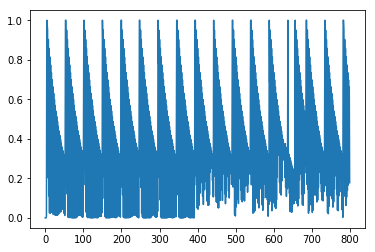

In [333]:
plt.plot(intensity[0:800])